# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [20]:
%matplotlib notebook

import logging
logging.basicConfig(level=logging.ERROR)


import calendar

from datetime import timedelta, datetime

from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.style.use('seaborn-whitegrid')
# plt.style.use('seaborn')
from matplotlib import cm

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',None)

from helper import *
from austria import Austria
from ecdc import ECDC

def predict_future(past_days, past_y, ndays=14, predict_days=30, degree_fit=2,window_size=14):
    '''
    @ndays: number of days to consider from the end for predicting future
    ''' 
    past_y = past_y.rolling(window_size).mean().tolist()
    future = np.arange(0,ndays+predict_days)
    past_days = past_days.dt.to_pydatetime()
    future_days = pd.date_range(start =past_days[-ndays], 
                                end =past_days[-1]+ timedelta(days=predict_days)).to_list()

    x = np.arange(ndays)
    z = np.polyfit(x,past_y[-ndays:], degree_fit)    
    p = np.poly1d(z)    
    return future_days, p(future)

def str2float(x):
    return float(str(x).replace(',','.'))



def plot_yearly(df, date_column, value_column, ax=None, title='', log=True, roll=14, plot_params={}):
    if not ax:
        f, ax = plt.subplots()
    for y in df.sort_values(by=date_column, ascending=False)[date_column].dt.year.unique():
        df_year = df[df[date_column].dt.year==y][[date_column, value_column]].rename(columns={value_column: f'{y}'})       
        df_year[date_column] = df_year[date_column].dt.strftime("%m-%d")
        ax.plot(df_year[date_column], df_year[f'{y}'].rolling(roll).mean(), label=f'{y}', marker='o', markersize=2, **plot_params)
        
    title = f'{title} ({roll} day average)' if roll>1 else title
    ax.set_title(title)
    ax.set_xlabel('')    
    pretty_plot(ax, major_locator=28)
#     plt.xticks( range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    if log:
        ax.set_yscale('log')
    plt.tight_layout()
    
def plot_yearly_avg(bezirk='Alle', log=False, roll=14, ax=None):
    if not ax:
        f, ax = plt.subplots()
    if bezirk != 'Alle':
        cases = AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk==bezirk]
    else:
        cases = AT.fälle_timeline_gkz.groupby(
                by='Time', as_index=False).agg(
                    'sum')
    for y in cases.sort_values(by='Time', ascending=False).Time.dt.year.unique():
        cases_year = cases[cases.Time.dt.year==y][['Time', 'AnzahlFaelle']].rename(columns={"AnzahlFaelle": f'{y}'})       
        cases_year['Time'] = cases_year['Time'].dt.strftime("%m-%d")
        ax.plot(cases_year['Time'], cases_year[f'{y}'].rolling(roll).mean(), label=f'{y}', marker='o', markersize=2)
        
    title = bezirk if bezirk != 'Alle' else 'Österreich'
    title = f'{title} - Cases ({roll} day average)' if roll>1 else title
    ax.set_title(title)
    ax.set_xlabel('')    
    pretty_plot(ax, major_locator=28)
#     plt.xticks( range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    if log:
        ax.set_yscale('log')
    plt.tight_layout()


### Data

In [21]:
def refresh_data():
    today =f'{datetime.now().year}_{datetime.now().month:02d}_{datetime.now().day:02d}'
    ecdc = ECDC()
    AT = Austria()
    print("TODAY: ", datetime.now())


    return AT, ecdc

AT, ecdc = refresh_data()

    

TODAY:  2021-09-07 11:42:08.940196


In [3]:
AT.fälle_timeline_gkz.Bezirk.unique(), AT.rdf_bundesland.Bundesland.unique()

(array(['Eisenstadt(Stadt)', 'Rust(Stadt)', 'Eisenstadt-Umgebung',
        'Güssing', 'Jennersdorf', 'Mattersburg', 'Neusiedl am See',
        'Oberpullendorf', 'Oberwart', 'Klagenfurt Stadt', 'Villach Stadt',
        'Hermagor', 'Klagenfurt Land', 'Sankt Veit an der Glan',
        'Spittal an der Drau', 'Villach Land', 'Völkermarkt', 'Wolfsberg',
        'Feldkirchen', 'Krems an der Donau(Stadt)', 'Sankt Pölten(Stadt)',
        'Waidhofen an der Ybbs(Stadt)', 'Wiener Neustadt(Stadt)',
        'Amstetten', 'Baden', 'Bruck an der Leitha', 'Gänserndorf',
        'Gmünd', 'Hollabrunn', 'Horn', 'Korneuburg', 'Krems(Land)',
        'Lilienfeld', 'Melk', 'Mistelbach', 'Mödling', 'Neunkirchen',
        'Sankt Pölten(Land)', 'Scheibbs', 'Tulln',
        'Waidhofen an der Thaya', 'Wiener Neustadt(Land)', 'Zwettl',
        'Linz(Stadt)', 'Steyr(Stadt)', 'Wels(Stadt)', 'Braunau am Inn',
        'Eferding', 'Freistadt', 'Gmunden', 'Grieskirchen',
        'Kirchdorf an der Krems', 'Linz-Land', 'Per

### Info

In [92]:
print("fälle_timeline_gkz", AT.fälle_timeline_gkz.columns)
print(AT.fälle_timeline_gkz.Bezirk.unique())
print()
print("fall_zählen", AT.fall_zählen.columns)
print(AT.fall_zählen.Bundesland.unique())
print()
print("rdf", rdf.columns)
print()
print("rdf_bundesland", rdf_bundesland.columns)
print(rdf_bundesland.Bundesland.unique())
print()
print("vaccines", vaccines.columns)

fälle_timeline_gkz Index(['Time', 'Bezirk', 'GKZ', 'AnzEinwohner', 'AnzahlFaelle',
       'AnzahlFaelleSum', 'AnzahlFaelle7Tage', 'SiebenTageInzidenzFaelle',
       'AnzahlTotTaeglich', 'AnzahlTotSum', 'AnzahlGeheiltTaeglich',
       'AnzahlGeheiltSum'],
      dtype='object')
['Eisenstadt(Stadt)' 'Rust(Stadt)' 'Eisenstadt-Umgebung' 'Güssing'
 'Jennersdorf' 'Mattersburg' 'Neusiedl am See' 'Oberpullendorf' 'Oberwart'
 'Klagenfurt Stadt' 'Villach Stadt' 'Hermagor' 'Klagenfurt Land'
 'Sankt Veit an der Glan' 'Spittal an der Drau' 'Villach Land'
 'Völkermarkt' 'Wolfsberg' 'Feldkirchen' 'Krems an der Donau(Stadt)'
 'Sankt Pölten(Stadt)' 'Waidhofen an der Ybbs(Stadt)'
 'Wiener Neustadt(Stadt)' 'Amstetten' 'Baden' 'Bruck an der Leitha'
 'Gänserndorf' 'Gmünd' 'Hollabrunn' 'Horn' 'Korneuburg' 'Krems(Land)'
 'Lilienfeld' 'Melk' 'Mistelbach' 'Mödling' 'Neunkirchen'
 'Sankt Pölten(Land)' 'Scheibbs' 'Tulln' 'Waidhofen an der Thaya'
 'Wiener Neustadt(Land)' 'Zwettl' 'Linz(Stadt)' 'Steyr(Stadt)'
 'Wel

## R eff.

<IPython.core.display.Javascript object>


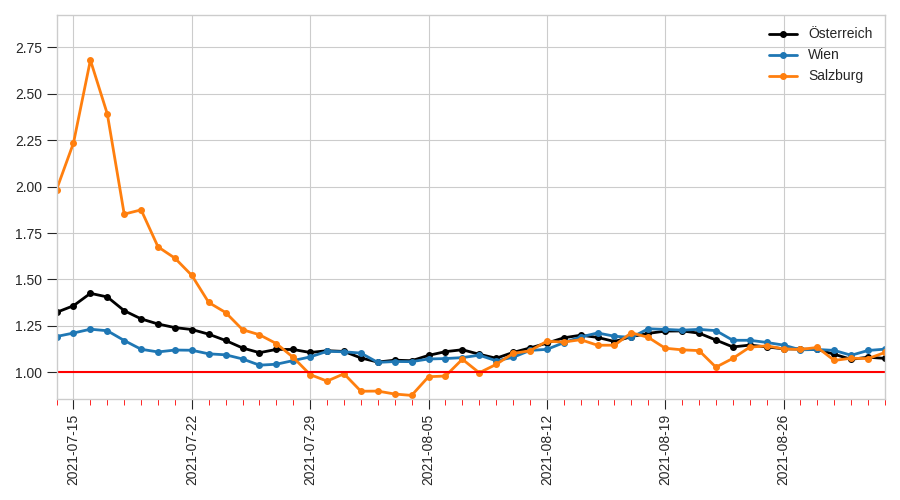

,Datum,R_eff,R_eff_lwr,R_eff_upr
Bundesland,,,,
Wien,2021-09-01,1.124335,1.094306,1.154764
Burgenland,2021-09-01,1.110549,0.998170,1.228837
Salzburg,2021-09-01,1.106448,1.047557,1.166926
Niederösterreich,2021-09-01,1.073850,1.032402,1.116103
Vorarlberg,2021-09-01,1.062493,0.991261,1.136161
Tirol,2021-09-01,1.056103,0.997970,1.115859
Kärnten,2021-09-01,1.046052,0.966015,1.129229
Oberösterreich,2021-09-01,1.032358,0.998939,1.066318
Steiermark,2021-09-01,1.027849,0.981215,1.075551


,Datum,R_eff,R_eff_lwr,R_eff_upr
536,2021-08-28,1.122556,1.105455,1.139787
537,2021-08-29,1.096477,1.079870,1.113209
538,2021-08-30,1.069586,1.053442,1.085851
539,2021-08-31,1.080812,1.064786,1.096957
540,2021-09-01,1.074463,1.058661,1.090380


In [22]:
NDAYS = 50
f, ax = plt.subplots(figsize=(9,5))
rdf, rdf_bundesland = AT.rdf_alle, AT.rdf_bundesland
ax.plot(rdf.Datum, rdf.R_eff, label='Österreich', color='k', linestyle='-', marker='o', 
        markersize=4, linewidth=2
       )

# bundesland = rdf_bundesland.Bundesland.unique()
# bundesland = ['Burgenland', 'Kärnten', 'Niederösterreich', 'Oberösterreich',
#        'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg', 'Wien', 'Alle']
bundesland = [  'Wien', 'Salzburg']
viridis = cm.get_cmap('viridis', len(bundesland))
for i, bnd in enumerate(bundesland):
    df = rdf_bundesland[rdf_bundesland.Bundesland==bnd].sort_values(by='Datum')
    ax.plot(df.Datum, df.R_eff, label=bnd, 
#             color=viridis.colors[i], 
#             alpha=0.5,
            linewidth=2,
            marker='o', 
            markersize=4
           )
    
    
ax.axhline(y=1, c='r')    
ndays = min(NDAYS,rdf.shape[0])
if ndays:
    plt.xlim((rdf.Datum.iloc[-ndays], rdf.Datum.iloc[-1]))
    plt.ylim((min(rdf.R_eff.iloc[-ndays:])-0.2,max(rdf.R_eff.iloc[-ndays:])+1.5))
else: pass
   
pretty_plot(ax, major_locator=7, minor_locator=1)

grouped = rdf_bundesland.groupby(by='Bundesland').agg(latest)
display(grouped.sort_values(by='R_eff', ascending=False))
# display(grouped[grouped.R_eff<0.95])
display(rdf.tail(5))

## Cases


### Weekly

<IPython.core.display.Javascript object>


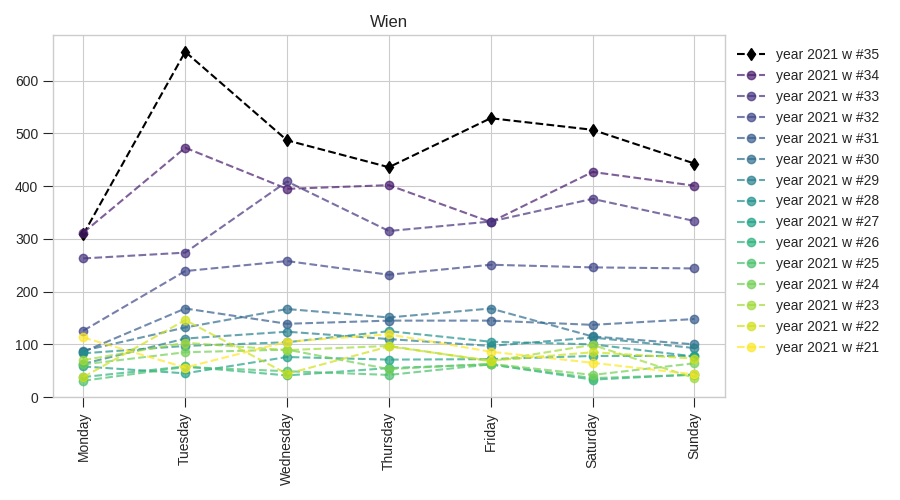

<IPython.core.display.Javascript object>


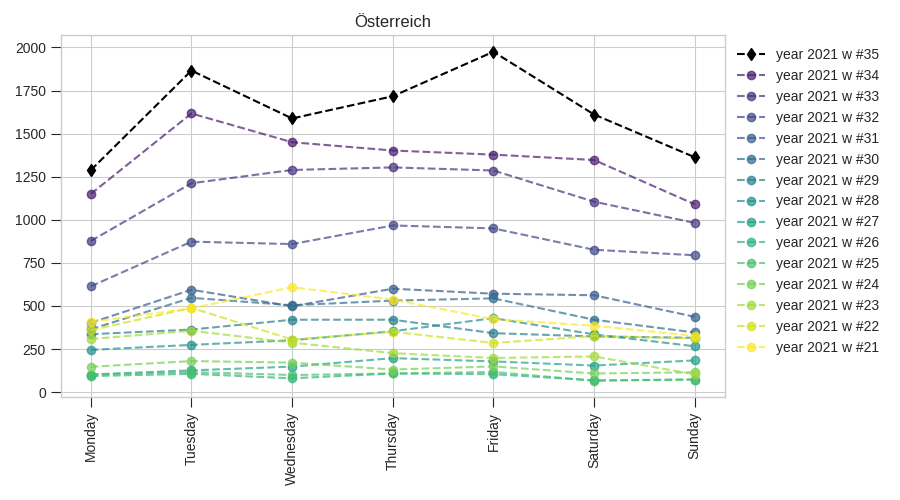

<AxesSubplot:title={'center':'Österreich'}>

In [23]:
HISTORY =15


AT.plot_cases_by_day_of_the_week(num_weeks_history=HISTORY, bezirk='Wien')
AT.plot_cases_by_day_of_the_week(num_weeks_history=HISTORY, bezirk='')



<IPython.core.display.Javascript object>


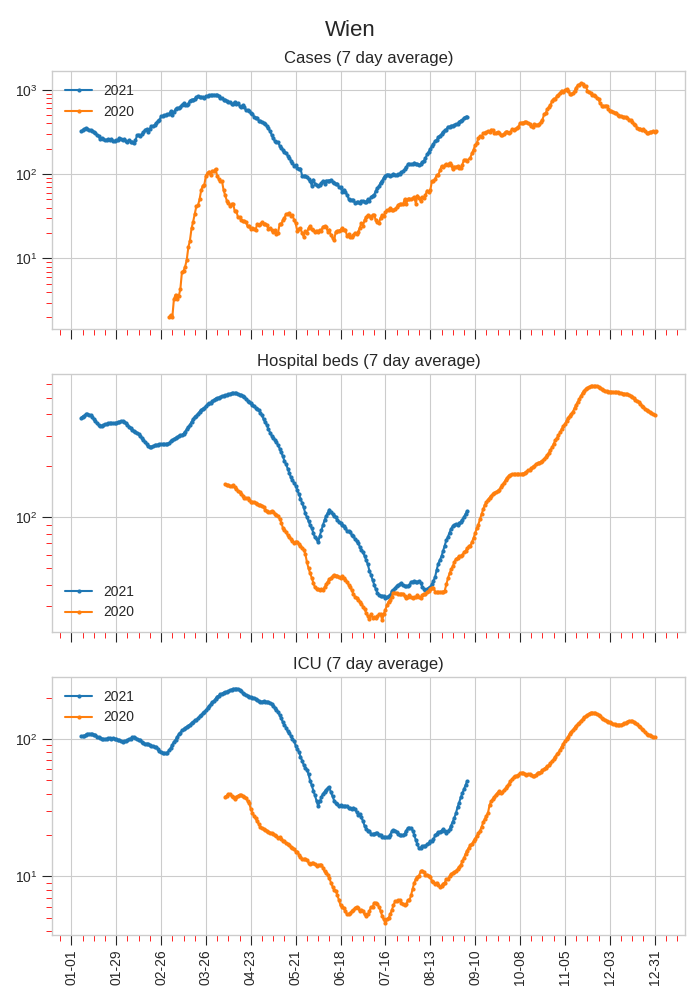

<IPython.core.display.Javascript object>


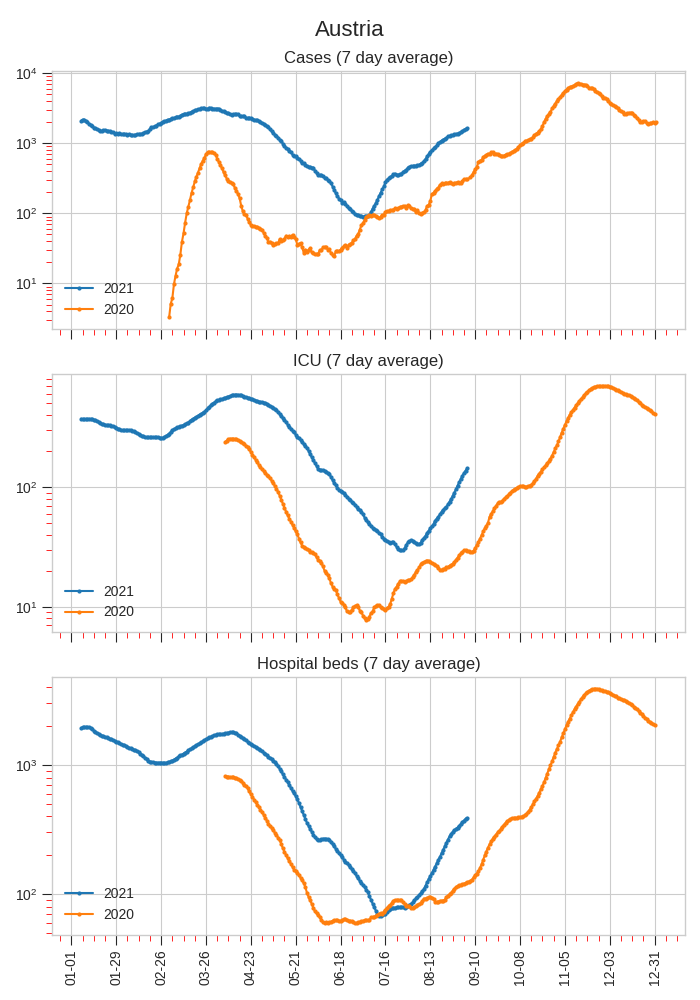

In [24]:
ROLL=7
f, ax = plt.subplots(nrows=3, figsize=(7,10), sharex=True)
# plot_yearly_avg(bezirk='Wien', log=True, roll=ROLL,ax=ax[0])
plot_yearly(AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk=='Wien'], ax=ax[0], title='Cases', date_column='Time', value_column='AnzahlFaelle', roll=ROLL)
plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Wien'], ax=ax[1], title='Hospital beds', date_column='MeldeDatum', value_column='FZHosp', roll=ROLL)
plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Wien'],ax=ax[2],  title='ICU', date_column='MeldeDatum', value_column='FZICU', roll=ROLL)
f.suptitle('Wien', fontsize=16)
plt.tight_layout()
# plot_yearly_avg(bezirk='Wien', log=True, roll=ROLL)
f.savefig('../../../Dropbox/covid/Wien.png')

f, ax = plt.subplots(nrows=3, figsize=(7,10), sharex=True)
plot_yearly( AT.fälle_timeline_gkz.groupby(
                by='Time', as_index=False).agg(
                    'sum'),
            title='Cases', date_column='Time', value_column='AnzahlFaelle', 
            ax=ax[0], log=True, roll=ROLL)

plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle'],ax=ax[2], title='Hospital beds', date_column='MeldeDatum', value_column='FZHosp', roll=7)
plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle'], ax=ax[1],title='ICU', date_column='MeldeDatum', value_column='FZICU', roll=7)
f.suptitle('Austria', fontsize=16)
plt.tight_layout()
f.savefig('../../../Dropbox/covid/Austria.png')

### Time Series

In [66]:
# ax = AT.plot_tägliche_erkrankungen(roll_days=7, ndays=0, bezirk='Wien')
# ax = AT.plot_tägliche_erkrankungen(roll_days=7, ndays=0, bezirk=None)
# plt.tight_layout()
# rdf_bundesland[rdf_bundesland.Bundesland=='Wien'].tail(1)



### Weekly Totals

In [8]:
def double(x):
#     return 2*sum(x)
    return 2*x.mean()

def weekly_totals(bezirk='Alle', nweeks=8):
    if bezirk != 'Alle':
        cases = AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk==bezirk]
    else:
        cases = AT.fälle_timeline_gkz.groupby(
                by='Time', as_index=False).agg({'AnzahlFaelle':'sum',
                                               'Bezirk':concat})
    grouped = cases.groupby(by=[cases.Time.dt.year, cases.Time.dt.isocalendar().week]).agg({#'Bezirk':latest,
                                                                                            'AnzahlFaelle':( concat, 'mean', 'sum'),
                                                                                              'Time': latest})    
    grouped.style.set_properties(**{'text-align': 'left'})
    display(grouped.sort_values(by=('Time','latest'), ascending=True).tail(nweeks))
    return


In [18]:
weekly_totals('Wien',nweeks=10)
weekly_totals(nweeks=5)


AnzahlFaelle                         Time
                                      concat        mean   sum     latest
Time week                                                                
2021 26           38, 58, 41, 55, 62, 33, 43   47.142857   330 2021-07-04
     27           58, 45, 76, 71, 72, 78, 78   68.285714   478 2021-07-11
     28       83, 97, 104, 125, 105, 100, 77   98.714286   691 2021-07-18
     29       63, 111, 124, 110, 97, 113, 93  101.571429   711 2021-07-25
     30     88, 132, 167, 151, 168, 115, 100  131.571429   921 2021-08-01
     31     86, 168, 139, 145, 145, 137, 148  138.285714   968 2021-08-08
     32    126, 239, 258, 232, 251, 246, 244  228.000000  1596 2021-08-15
     33    263, 274, 409, 315, 333, 376, 334  329.142857  2304 2021-08-22
     34    312, 473, 395, 402, 332, 427, 401  391.714286  2742 2021-08-29
     35    309, 655, 487, 436, 529, 507, 443  480.857143  3366 2021-09-05

AnzahlFaelle                      \
                                             concat         mean    sum   
Time week                                                                 
2021 31           402, 594, 498, 600, 571, 562, 437   523.428571   3664   
     32           614, 873, 859, 967, 950, 826, 794   840.428571   5883   
     33      877, 1212, 1289, 1304, 1286, 1105, 982  1150.714286   8055   
     34    1150, 1617, 1450, 1402, 1378, 1347, 1090  1347.714286   9434   
     35    1288, 1866, 1588, 1717, 1975, 1611, 1363  1629.714286  11408   

                Time  
              latest  
Time week             
2021 31   2021-08-08  
     32   2021-08-15  
     33   2021-08-22  
     34   2021-08-29  
     35   2021-09-05

### Yearly - rolling average

#### Cases

In [190]:
AT.fälle_timeline_gkz.Bezirk.unique()

array(['Eisenstadt(Stadt)', 'Rust(Stadt)', 'Eisenstadt-Umgebung',
       'Güssing', 'Jennersdorf', 'Mattersburg', 'Neusiedl am See',
       'Oberpullendorf', 'Oberwart', 'Klagenfurt Stadt', 'Villach Stadt',
       'Hermagor', 'Klagenfurt Land', 'Sankt Veit an der Glan',
       'Spittal an der Drau', 'Villach Land', 'Völkermarkt', 'Wolfsberg',
       'Feldkirchen', 'Krems an der Donau(Stadt)', 'Sankt Pölten(Stadt)',
       'Waidhofen an der Ybbs(Stadt)', 'Wiener Neustadt(Stadt)',
       'Amstetten', 'Baden', 'Bruck an der Leitha', 'Gänserndorf',
       'Gmünd', 'Hollabrunn', 'Horn', 'Korneuburg', 'Krems(Land)',
       'Lilienfeld', 'Melk', 'Mistelbach', 'Mödling', 'Neunkirchen',
       'Sankt Pölten(Land)', 'Scheibbs', 'Tulln',
       'Waidhofen an der Thaya', 'Wiener Neustadt(Land)', 'Zwettl',
       'Linz(Stadt)', 'Steyr(Stadt)', 'Wels(Stadt)', 'Braunau am Inn',
       'Eferding', 'Freistadt', 'Gmunden', 'Grieskirchen',
       'Kirchdorf an der Krems', 'Linz-Land', 'Perg', 'Ried im In

In [191]:
# ROLL = 7

# # plot_yearly()
# plot_yearly_avg(bezirk='Wien', log=True, roll=ROLL)
# plot_yearly_avg(log=True, roll=ROLL)


#### ICU Admissions

In [192]:
# plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle'], title='Österreich - ICU', date_column='MeldeDatum', value_column='FZICU', roll=7)
# plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Wien'], title='Wien - ICU', date_column='MeldeDatum', value_column='FZICU', roll=7)

#### Hospital Admissions

In [193]:
# plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle'], title='Österreich - hospital beds', date_column='MeldeDatum', value_column='FZHosp', roll=7)
# plot_yearly(AT.fall_zählen[AT.fall_zählen.Bundesland=='Wien'], title='Wien - hospital beds', date_column='MeldeDatum', value_column='FZHosp', roll=7)

In [194]:
# def predict_wien(df, rdf, predict_days=10):
#     display(rdf.tail(5))
#     past_days = df.Time
#     past_cases =  list(df.AnzahlFaelle)
    
# #     df = rdf_bundesland[rdf_bundesland.Bundesland=='Wien'].sort_values(by='Datum')

#     future = np.arange(0,predict_days)
#     past_days = past_days.dt.to_pydatetime()
#     x = pd.date_range(start =past_days[-1], 
#                             end =past_days[-1]+ timedelta(days=predict_days)).to_list()
    
#     y = np.zeros(len(x))
#     y[0] = past_cases[-1]
#     for i in range(1, len(x)):
#         y[i] = rdf.R_eff.iloc[-1]*y[i-1]
        
#     return pd.DataFrame({'Time':x,
#                          'AnzahlFaelle':y})
    
# wien_cases = AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk=='Wien']
# # test = predict_wien(predict_days=5,df=wien_cases[:-5], rdf=rdf_bundesland[rdf_bundesland.Bundesland=='Wien'].iloc[:-5])
# # display(test)
# # display(wien_cases.rolling(7)[['Time', 'AnzahlFaelle']])


# f, ax = plt.subplots(figsize=(9,6))
# ax.bar(wien_cases.Time, wien_cases.AnzahlFaelle, color='C0')
# ax.plot(wien_cases.Time, wien_cases.AnzahlFaelle.rolling(7).mean(), color='C1', marker='o', markersize=1, linewidth=1)

# plt.title('Wien')
# HISTORY = 100
# # ax.xaxis.set_major_locator(MultipleLocator(28))
# # ax.xaxis.set_minor_locator(MultipleLocator(5))
# # ax.xaxis.grid(True, which='major')

# # ax.tick_params(which='major', length=7)
# # ax.tick_params(which='minor', length=4, color='r')

# plt.xticks(rotation=90)
# pretty_plot(ax)

#### Wien

<IPython.core.display.Javascript object>


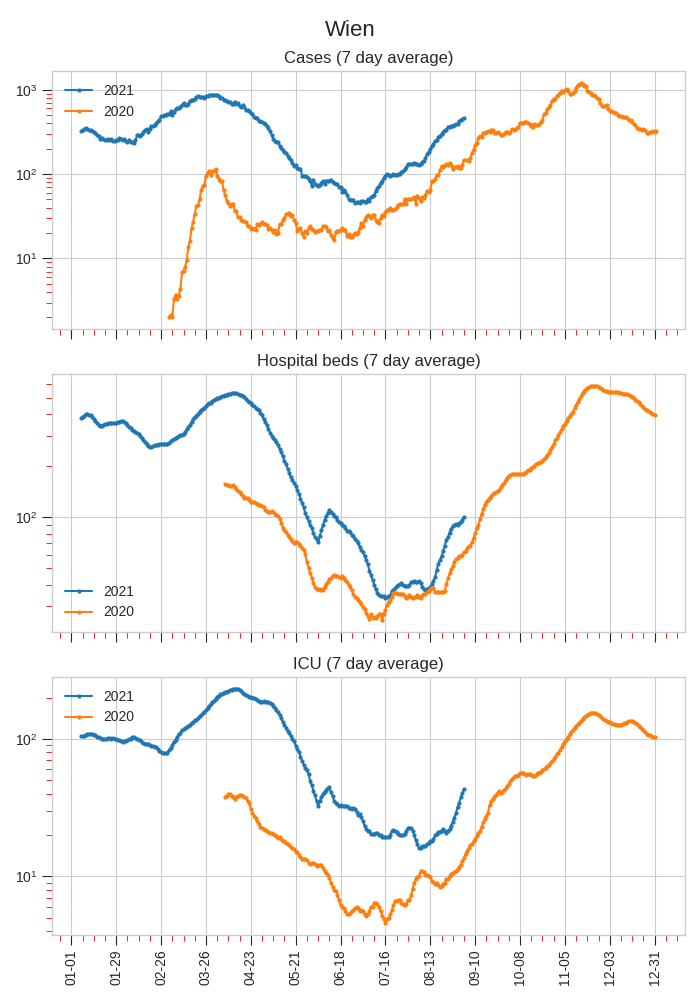

#### Österreich

<IPython.core.display.Javascript object>


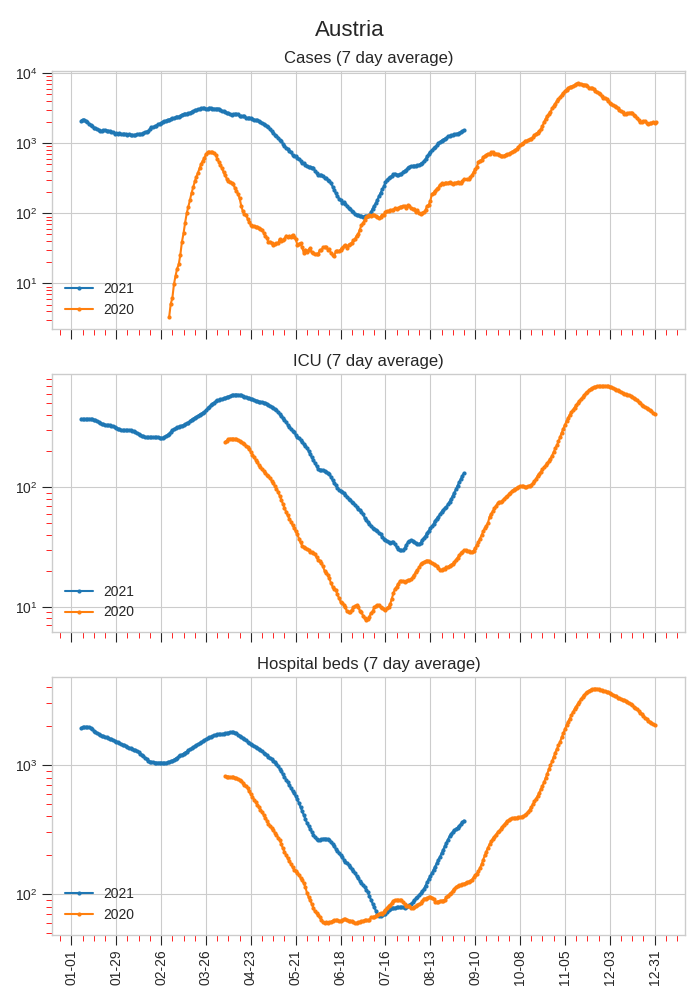

## Positivity Rate

2021-09-03 00:00:00


<IPython.core.display.Javascript object>


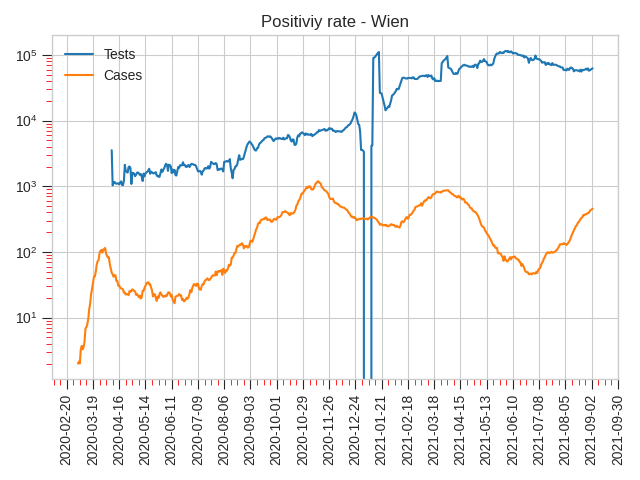

2021-09-03 00:00:00


<IPython.core.display.Javascript object>


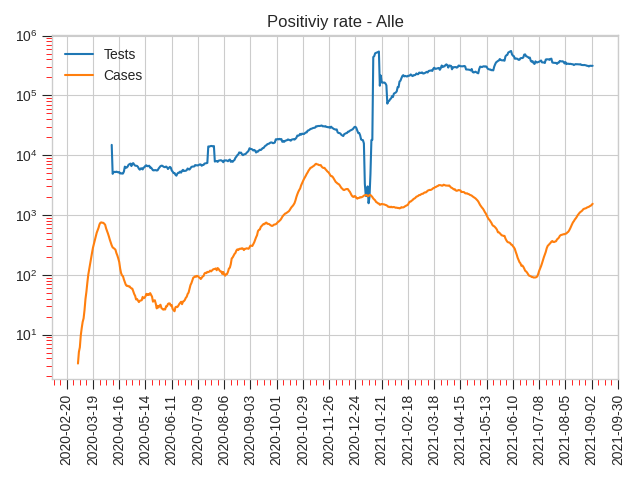

In [182]:
AT.plot_positivity_rate(bundesland='Wien', log=True)
AT.plot_positivity_rate(bundesland='Alle', log=True)

class AT1:
    def plot_positivity_rate(self, bundesland='Alle', **kwargs):
        cases = self.fall_zählen[self.fall_zählen.Bundesland == bundesland]

        if bundesland == 'Alle':
            timeline = self.fälle_timeline_gkz.groupby(
                by='Time', as_index=False).agg(
                    'sum')  #[self.fälle_timeline_gkz.Bezirk == bezirk]
        else:
            timeline = self.fälle_timeline_gkz[self.fälle_timeline_gkz.Bezirk
                                               == bundesland]

        print(cases.MeldeDatum.max())
        f, ax = plt.subplots()
        #def plot_yearly(df, date_column, value_column, ax=None, title='', log=True, roll=14, plot_params={}):
#         plot_yearly(cases, 'MeldeDatum', value_column, ax=None, title='', log=True, roll=14, plot_params={})
        ax.plot(cases.MeldeDatum,
                cases.TestGesamt.diff().rolling(7).mean(),
                label='Tests')
        
        
        ax.plot(timeline.Time,
                timeline.AnzahlFaelle.rolling(7).mean(),
                label='Cases')

        pretty_plot(ax, title=f'Positiviy rate - {bundesland}', **kwargs)
        return ax

## Corona Ampel

In [19]:
ampel = AT.ampel_aktuell

ampel.sort_values('Warnstufe', ascending=False).head(10)
ampel.groupby('Warnstufe').agg({'Name':concat, 'Region': 'count'})

,Name,Region
Warnstufe,,
2,"Burgenland, Kärnten, Niederösterreich, Steiermark, Tirol, None",6
3,"Oberösterreich, Salzburg, Vorarlberg, Wien",4


## Future Occupancy

In [177]:
NDAYS=60
latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
print(f'As of {AT.fall_zählen.MeldeDatum.max()}')
data = []
for bundesland in AT.fall_zählen.Bundesland.unique():
    bundesland_data = {'bundesland': bundesland}
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]
    bundesland_data['ICUFree'] = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]
    bundesland_data['HospFree'] = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]
    predict_days =  300
    days_left_icu = []
    days_left_hosp = []
    for degree_fit in (1,2,3):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_icu.append( np.argmax(y>=limit_ICU)-NDAYS)
        else:
            days_left_icu.append(1000)

        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_hosp.append( np.argmax(y>=limit_Hosp)-NDAYS)
        else:
            days_left_hosp.append( 1000)


        
    bundesland_data['daysLeftICU'] = days_left_icu    
    bundesland_data['ICUMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_icu)))
    bundesland_data['ICUMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_icu)))
    bundesland_data['daysLeftHosp'] = days_left_hosp
    
    bundesland_data['HospMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_hosp)))
    bundesland_data['HospMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_hosp)))

    data.append(bundesland_data)
    
df_future = pd.DataFrame(data)
df_future.sort_values(by='ICUFree')

As of 2021-09-03 00:00:00


,bundesland,ICUFree,HospFree,daysLeftICU,ICUMax_worst,ICUMax_best,daysLeftHosp,HospMax_worst,HospMax_best
6,Tirol,19,126,"[258, 38, 1000]",2021-10-11,2024-05-30,"[1000, 78, 1000]",2021-11-20,2024-05-30
0,Burgenland,34,102,"[1000, 167, 1000]",2022-02-17,2024-05-30,"[1000, 88, 54]",2021-10-27,2024-05-30
5,Steiermark,37,132,"[200, 44, 42]",2021-10-15,2022-03-22,"[282, 59, 38]",2021-10-11,2022-06-12
4,Salzburg,40,59,"[1000, 106, 1000]",2021-12-18,2024-05-30,"[267, 42, 23]",2021-09-26,2022-05-28
1,Kärnten,45,213,"[1000, 83, 59]",2021-11-01,2024-05-30,"[1000, 134, 1000]",2022-01-15,2024-05-30
3,Oberösterreich,45,182,"[1000, 37, 25]",2021-09-28,2024-05-30,"[241, 46, 30]",2021-10-03,2022-05-02
7,Vorarlberg,52,87,"[1000, 97, 1000]",2021-12-09,2024-05-30,"[1000, 91, 1000]",2021-12-03,2024-05-30
2,Niederösterreich,98,79,"[1000, 69, 33]",2021-10-06,2024-05-30,"[134, 24, 18]",2021-09-21,2022-01-15
8,Wien,310,664,"[1000, 160, 64]",2021-11-06,2024-05-30,"[1000, 95, 64]",2021-11-06,2024-05-30
9,Alle,680,1644,"[1000, 85, 58]",2021-10-31,2024-05-30,"[1000, 69, 50]",2021-10-23,2024-05-30


### Plots

<IPython.core.display.Javascript object>


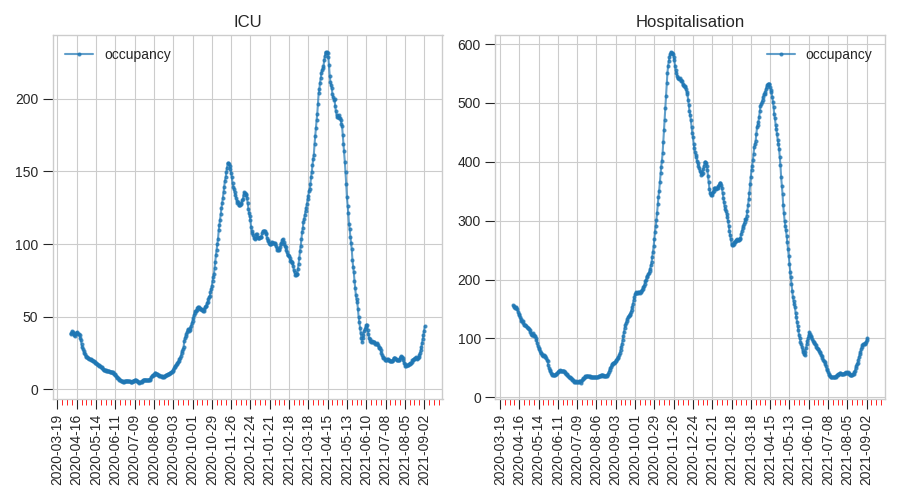

<IPython.core.display.Javascript object>


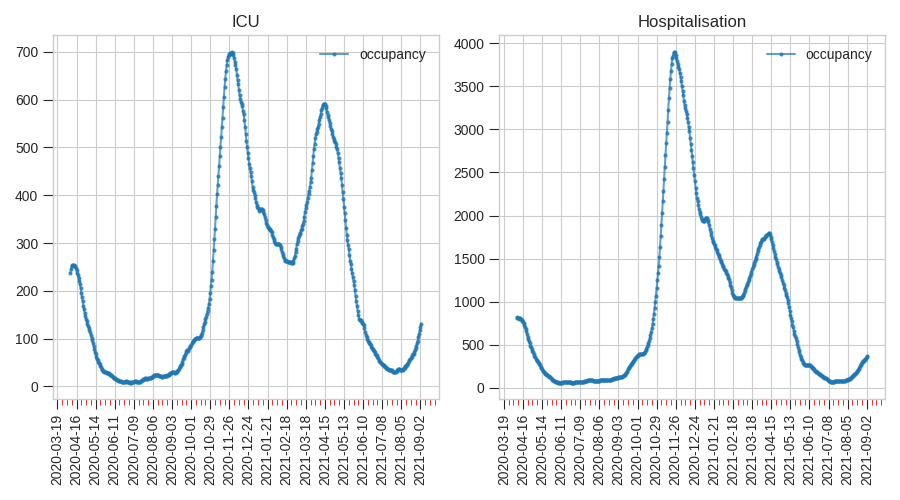

In [178]:
PREDICTION_HISTORY = 30
NDAYS=75

latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
for bundesland in [ 'Wien', 'Alle']:
    f, ax = plt.subplots(ncols=2,sharex=True, figsize=(9,5))
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + \
                latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + \
                 latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]

    predict_days =  max(int(latest_df.FZICUFree.iloc[0]),PREDICTION_HISTORY)

    ax[0].plot(df.MeldeDatum, df.FZICU.rolling(7).mean(), label='occupancy', marker='o',markersize=2, alpha=0.7)
    ax[1].plot(df.MeldeDatum, df.FZHosp.rolling(7).mean(), label='occupancy', marker='o',markersize=2, alpha=0.7)

    pretty_plot(ax[0], title=f'ICU')# ({min(days_left_ICU)} days)')
#     if not days_left_Hosp:
#         days_left_Hosp = [0]
    pretty_plot(ax[1],title=f'Hospitalisation')# ({min(days_left_Hosp)} days)')        
#     plt.savefig(f'ICU_{today}_{bundesland}.png')



## Bed capacity

<IPython.core.display.Javascript object>


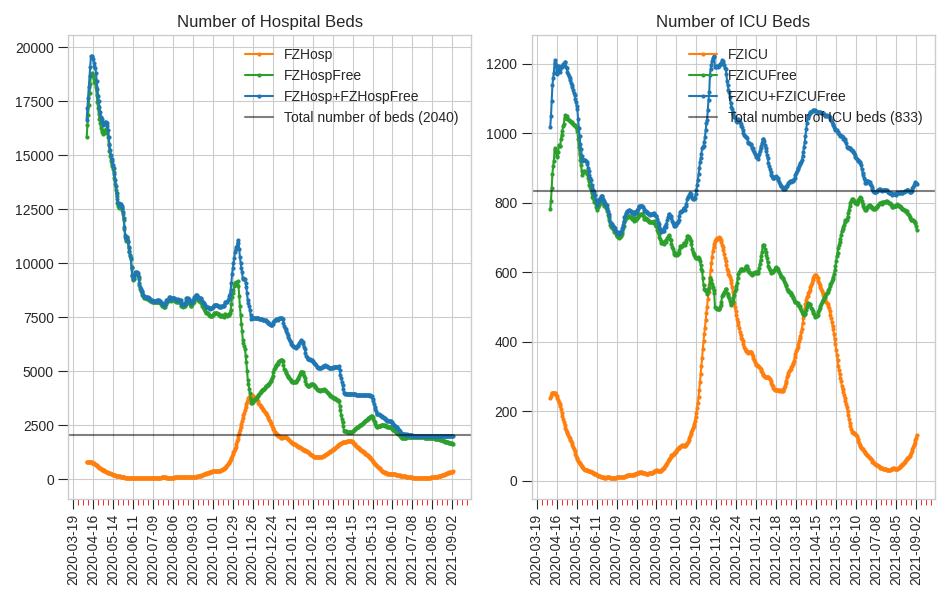

In [179]:
df = AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle']
f,ax = plt.subplots(ncols=2, figsize=(9.5,6))
def plot_column(ax, col_names, roll_days=0, color='C0'):    
    if isinstance(col_names, list):                
        ycol = sum([df[col] for col in col_names])
        label = '+'.join(col_names)
    else:
        ycol = df[col_names]
        label = col_names   
        
    if roll_days:
        
        ycol = ycol.rolling(7).mean()
        
        
    ax.plot(df.MeldeDatum, ycol, label=label,markersize=2, marker='o', color=color)    
#     pass

plot_column(ax[0],col_names='FZHosp', roll_days=7, color='C1')
plot_column(ax[0],col_names= 'FZHospFree', roll_days=7,color='C2')
plot_column(ax[0],col_names=['FZHosp', 'FZHospFree'], roll_days=14, color='C0')
ax[0].axhline(y=df.FZHospFree.iloc[-1]+df.FZHosp.iloc[-1],color='k', label=f'Total number of beds ({limit_Hosp})',alpha=0.5)
plot_column(ax[1],col_names='FZICU', roll_days=7,color='C1')
plot_column(ax[1],col_names= 'FZICUFree', roll_days=7,color='C2')
plot_column(ax[1],col_names=['FZICU', 'FZICUFree'], roll_days=14,color='C0')
ax[1].axhline(y=df.FZICUFree.iloc[-1]+df.FZICU.iloc[-1],color='k', label=f'Total number of ICU beds ({limit_ICU})',alpha=0.5)
# ax[0].plot(df.MeldeDatum, (df.FZHosp+df.FZHospFree).rolling(7).mean(), label='FZHosp+FZHospFree',markersize=2, marker='o')    
# ax[0].plot(df.MeldeDatum, df.FZHosp.rolling(7).mean(), label='FZHosp',markersize=2, marker='o')    
# ax[0].plot(df.MeldeDatum, df.FZHospFree.rolling(7).mean(), label='FZHospFree',markersize=2, marker='o') 
# ax[1].plot(df.MeldeDatum, (df.FZICU+df.FZICUFree).rolling(7).mean(), label='FZICU+FZICUFree',markersize=2, marker='o')    
# ax[1].plot(df.MeldeDatum, df.FZICU.rolling(7).mean(), label='FZICU',markersize=2, marker='o')    
# ax[1].plot(df.MeldeDatum, df.FZICUFree.rolling(7).mean(), label='FZICUFree',markersize=2, marker='o')    
# 
# 
ax[0].set_title('Number of Hospital Beds')
ax[1].set_title('Number of ICU Beds')
pretty_plot(ax[0])
pretty_plot(ax[1])

## Deaths

In [90]:
from gestorbene import Gestorbene
G = Gestorbene()
max(G.under_65.week_end)

  0%|          | 0/40461 [00:00<?, ?it/s]

Timestamp('2021-08-15 00:00:00')

### Overall Deaths

<IPython.core.display.Javascript object>


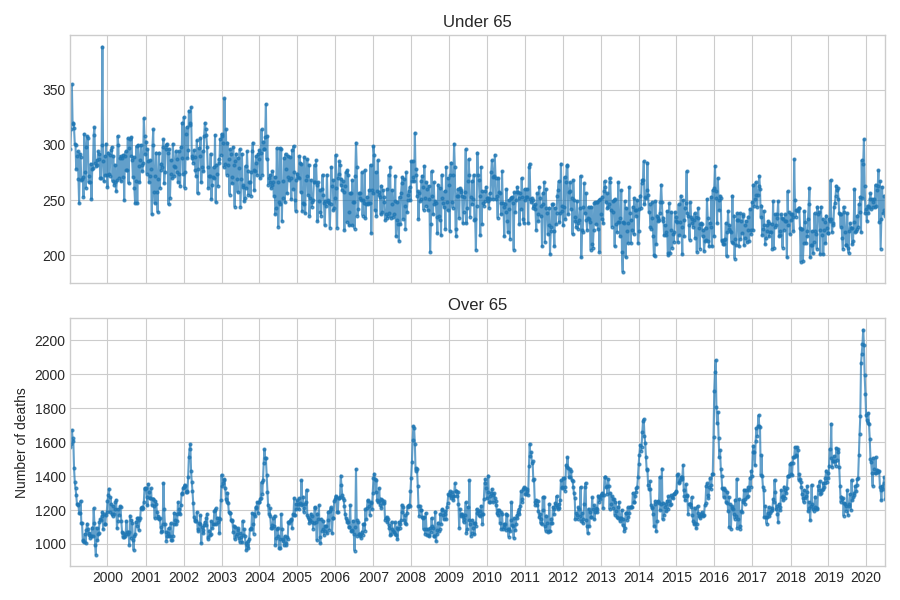

In [220]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y'))
plt.tight_layout()

### Group by month and year

<IPython.core.display.Javascript object>


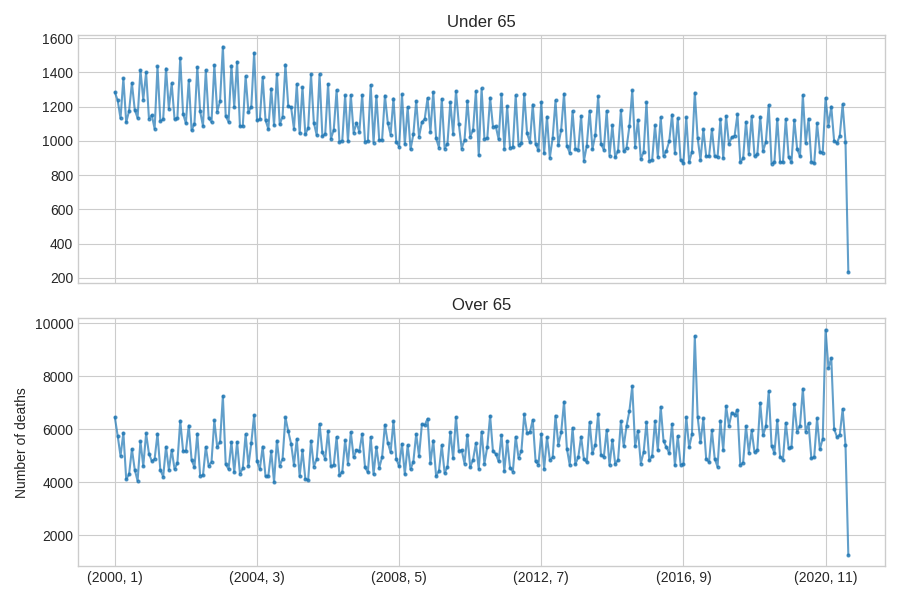

In [221]:
from matplotlib.ticker import FormatStrFormatter
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='M')

f, ax = plt.subplots(figsize=(9,6), sharex=True,nrows=2)
G.under_65.groupby(by=[G.under_65.week_end.dt.year, G.under_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(by=[G.over_65.week_end.dt.year, G.over_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
# ax[1].xaxis.set_major_locator(plt.MaxNLocator(50));

# plt.xticks(dates,zip( dates.strftime('%Y'),dates.strftime('%M')));
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%Y'));

plt.tight_layout()

### By Sex

<IPython.core.display.Javascript object>


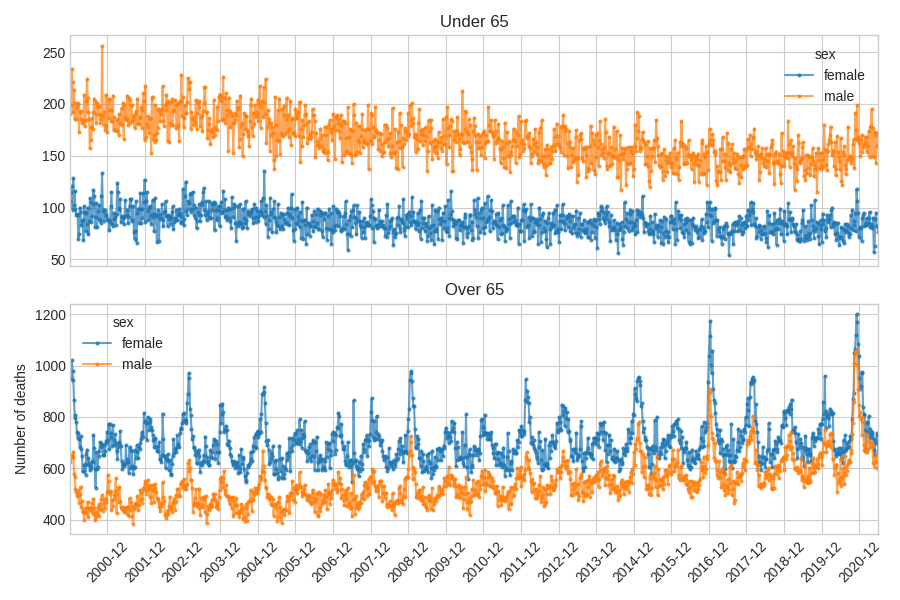

In [222]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.xticks(rotation=45)

plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y-%m'));
plt.tight_layout()

### Yearly - cumulative, continuous

In [223]:
def earliest(x):
    return x.iloc[0]

df = pd.concat([G.under_65, G.over_65])
g = df.groupby(by=df.week_end.dt.strftime("%y.%m"), as_index=False).agg({'week_end':latest,'F-ANZ-1':'sum'}).sort_values(by='week_end')
print(g.columns)
display(g.head())

Index(['week_end', 'F-ANZ-1'], dtype='object')


,week_end,F-ANZ-1
0,2000-01-30,7736
1,2000-02-27,6982
2,2000-03-26,6119
3,2000-04-30,7229
4,2000-05-28,5225


<IPython.core.display.Javascript object>


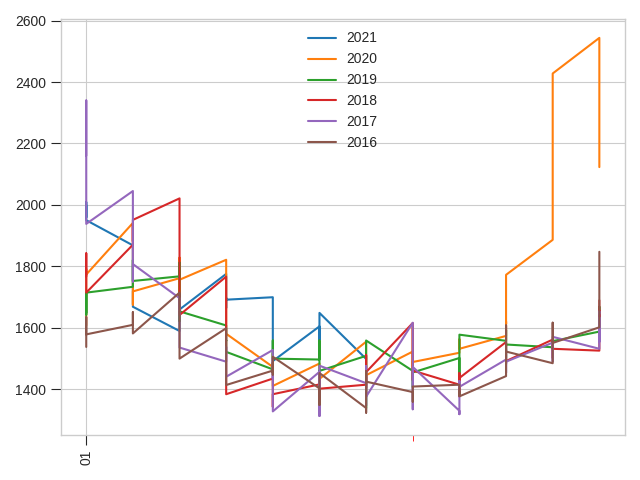

Index(['C-KALWOCHE-0', 'C-B00-0', 'C-ALTERGR65-0', 'C-C11-0', '2021',
       'week_begin', 'week_end', 'sex', 'bundesland'],
      dtype='object')


,week_end,2021
0,2021-01-03,1999
1,2021-01-10,1962
2,2021-01-17,1959
3,2021-01-24,2009
4,2021-01-31,1950
5,2021-02-07,1868
6,2021-02-14,1759
7,2021-02-21,1722
8,2021-02-28,1668
9,2021-03-07,1589


Index(['C-KALWOCHE-0', 'C-B00-0', 'C-ALTERGR65-0', 'C-C11-0', '2020',
       'week_begin', 'week_end', 'sex', 'bundesland'],
      dtype='object')


,week_end,2020
0,2020-01-05,1607
1,2020-01-12,1691
2,2020-01-19,1791
3,2020-01-26,1773
4,2020-02-02,1941
5,2020-02-09,1675
6,2020-02-16,1714
7,2020-02-23,1718
8,2020-03-01,1761
9,2020-03-08,1734


Index(['C-KALWOCHE-0', 'C-B00-0', 'C-ALTERGR65-0', 'C-C11-0', '2019',
       'week_begin', 'week_end', 'sex', 'bundesland'],
      dtype='object')


,week_end,2019
0,2019-01-06,1648
1,2019-01-13,1710
2,2019-01-20,1642
3,2019-01-27,1714
4,2019-02-03,1733
5,2019-02-10,1797
6,2019-02-17,1820
7,2019-02-24,1752
8,2019-03-03,1767
9,2019-03-10,1812


Index(['C-KALWOCHE-0', 'C-B00-0', 'C-ALTERGR65-0', 'C-C11-0', '2018',
       'week_begin', 'week_end', 'sex', 'bundesland'],
      dtype='object')


,week_end,2018
0,2018-01-07,1767
1,2018-01-14,1842
2,2018-01-21,1786
3,2018-01-28,1714
4,2018-02-04,1870
5,2018-02-11,1938
6,2018-02-18,1881
7,2018-02-25,1951
8,2018-03-04,2021
9,2018-03-11,1965


Index(['C-KALWOCHE-0', 'C-B00-0', 'C-ALTERGR65-0', 'C-C11-0', '2017',
       'week_begin', 'week_end', 'sex', 'bundesland'],
      dtype='object')


,week_end,2017
0,2017-01-01,2160
1,2017-01-08,2293
2,2017-01-15,2340
3,2017-01-22,2060
4,2017-01-29,1938
5,2017-02-05,2045
6,2017-02-12,1874
7,2017-02-19,1750
8,2017-02-26,1807
9,2017-03-05,1696


Index(['C-KALWOCHE-0', 'C-B00-0', 'C-ALTERGR65-0', 'C-C11-0', '2016',
       'week_begin', 'week_end', 'sex', 'bundesland'],
      dtype='object')


,week_end,2016
0,2016-01-03,1537
1,2016-01-10,1634
2,2016-01-17,1626
3,2016-01-24,1608
4,2016-01-31,1578
5,2016-02-07,1609
6,2016-02-14,1650
7,2016-02-21,1621
8,2016-02-28,1581
9,2016-03-06,1714


In [224]:
df = pd.concat([G.under_65, G.over_65])
df = df[df.week_end.dt.year>2015]
years = df.sort_values(by='week_end', ascending=False).week_end.dt.year.unique()
# print(years)
def plot_yearly_deaths(roll=14):
    f, ax = plt.subplots()
    for y in years:
        deaths_year = df[df.week_end.dt.year==y].rename(columns={"F-ANZ-1": f'{y}'})
        print(deaths_year.columns)
        g = deaths_year.groupby(by=deaths_year.week_end, as_index=False).agg({f'{y}':'sum'})
        display(g)
#         grouped = deaths_year.groupby(by= deaths_year.week_end.dt.strftime("%y.%m"), 
#                                       as_index=False).agg({'week_end':latest,
#                                                             f'{y}':'sum'}).sort_values(by='week_end')
#         deaths_year['Time'] = deaths_year.week_end.dt.strftime("%m.%d")
        ax.plot(g.week_end.dt.strftime("%m"), #, deaths_year['Time'],
                g[f'{y}'], 
                label=f'{y}')
#         break
    pretty_plot(ax)

plot_yearly_deaths()


In [225]:
G.under_65.bundesland.unique()

array(['Burgenland ', 'Kärnten ', 'Niederösterreich ', 'Oberösterreich ',
       'Salzburg ', 'Steiermark ', 'Tirol ', 'Vorarlberg ', 'Wien '],
      dtype=object)

### Yearly

<IPython.core.display.Javascript object>


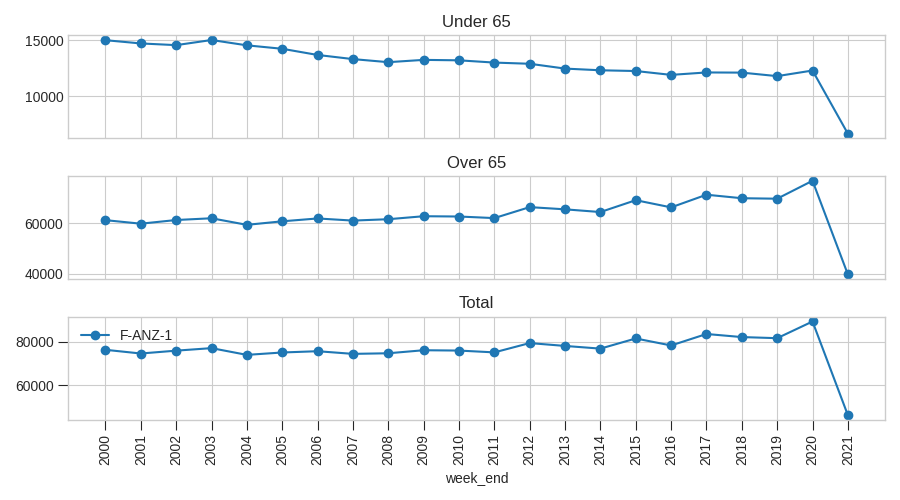

In [226]:
current_year = datetime.now().year
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,5),nrows=len(dfs), sharex=True, sharey=False)
i = 0
for title, df in dfs.items():
    grouped = df.groupby(by=[df.week_end.dt.year]).agg('sum')
    grouped.head()
    grouped['F-ANZ-1'].plot(ax=ax[i], marker='o', title=title)
    i += 1
# 
pretty_plot(ax[-1],xticks=[df.week_end.dt.year.unique(),])


### Total number of deaths in Austria in 2020

<IPython.core.display.Javascript object>


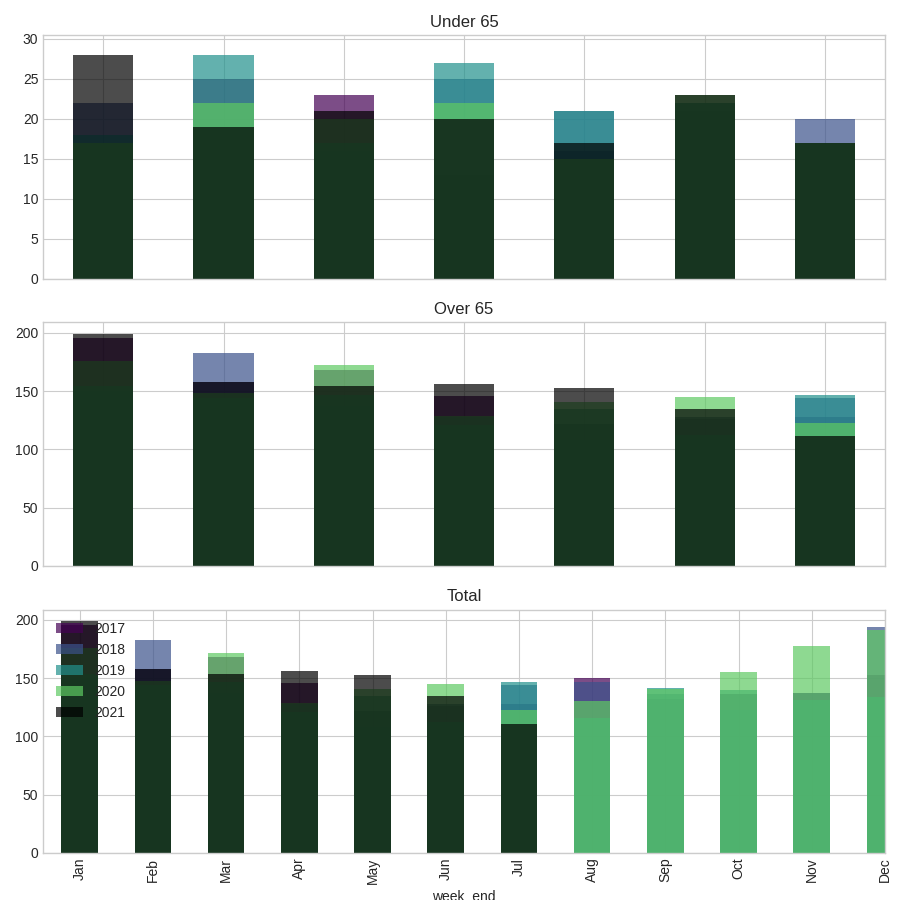

In [227]:
all_deaths = pd.concat([G.under_65, G.over_65])
NUM_YEARS = 5

YEARS = sorted(list(all_deaths.week_end.dt.year.unique()))[-NUM_YEARS:]
viridis = cm.get_cmap('viridis', len(YEARS))

f, ax = plt.subplots(figsize=(9,9),nrows=len(dfs), sharex=True, sharey=False)
j = -1
for title, all_deaths in dfs.items():
    j += 1
    for i, y in enumerate(YEARS):    
        if y == current_year:
#             alpha=1
            color='k'
        else:
            alpha=0.7
            color=viridis.colors[i]
            
        df_year = all_deaths[all_deaths.week_end.dt.year == y]
        grouped = df_year.groupby(by=[all_deaths.week_end.dt.month]).agg(latest)        
        grouped['F-ANZ-1'].plot.bar(ax=ax[j],label=y, title=title,color=color, alpha=alpha)
        plt.tight_layout()
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);
plt.legend(loc='best')


### COVID

### All deaths

In [228]:
# F-ANZ-1
all_deaths = pd.concat([G.under_65, G.over_65])
# all_deaths[ == 2020]['F-ANZ-1'].sum()
all_deaths.groupby(by=all_deaths.week_end.dt.year).sum().tail(12)

,F-ANZ-1
week_end,
2010,75883
2011,75052
2012,79313
2013,78003
2014,76774
2015,81421
2016,78219
2017,83471
2018,82063


### Cumulative deaths in a year

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


<IPython.core.display.Javascript object>


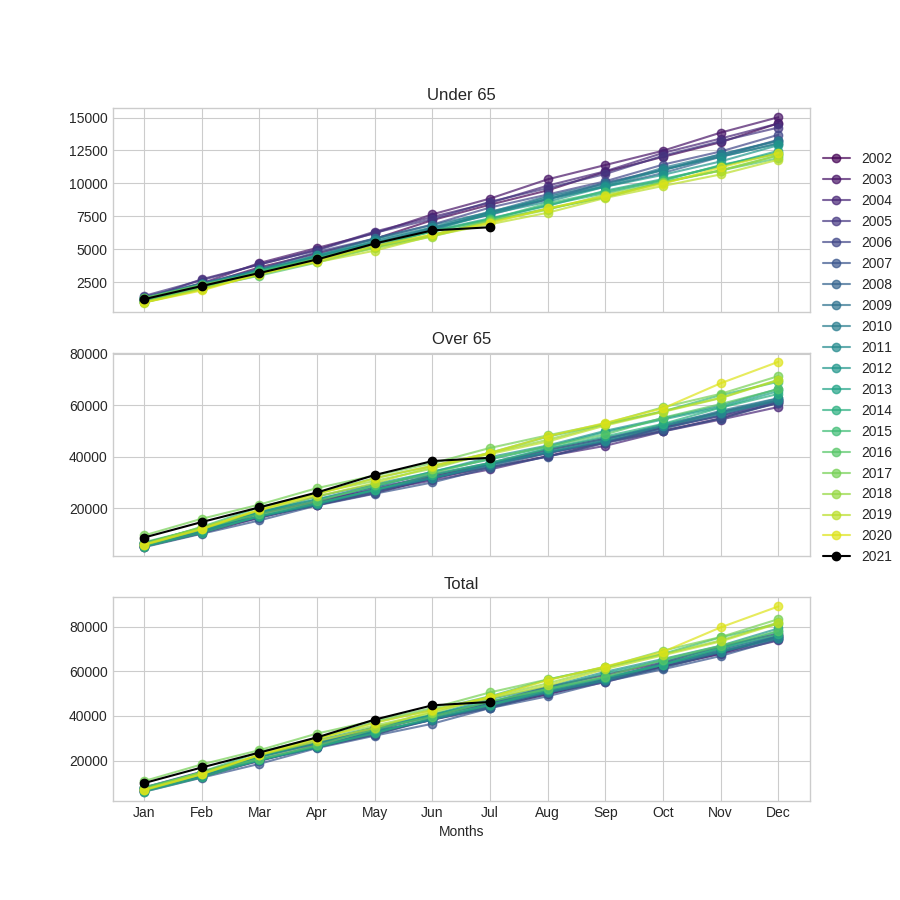

<ipython-input-229-943d4e1a9430>:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


In [229]:
current_year = datetime.now().year
NUM_YEARS = 20

YEARS = sorted(list(all_deaths.week_end.dt.year.unique()))
if NUM_YEARS:
    YEARS = YEARS[-NUM_YEARS:]
    
print(YEARS)
viridis = cm.get_cmap('viridis', len(YEARS))

# df.head()
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,9),nrows=len(dfs), sharex=True, sharey=False)
j = -1
for title, all_deaths in dfs.items():
    j += 1
    for i, y in enumerate(YEARS):    
        if y == current_year:
            alpha=1
            color='k'
        else:
            alpha=0.7
            color=viridis.colors[i]
            
        df_year = all_deaths[all_deaths.week_end.dt.year == y]
        grouped = df_year.groupby(by=[all_deaths.week_end.dt.month]).agg('sum')        
        grouped['F-ANZ-1'].cumsum().plot(ax=ax[j], marker='o',label=y, title=title,c=color, alpha=alpha)
    

plt.xlabel('Months')    
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(bbox_to_anchor=(1, 1.1), loc='lower left')    
# ax[0].legend(bbox_to_anchor=(1, 0.5), loc='upper left')    

plt.tight_layout()
    


## Monthly deaths comparison, year wise

In [152]:
def compare_months_years(df, title='', from_year=None):
    if from_year:
        df = df[df.week_end.dt.year>=from_year]
        
    f, ax = plt.subplots()
    df.groupby([ df.week_end.dt.month, df.week_end.dt.year]).sum()['F-ANZ-1'].unstack().plot.bar(ax=ax, 
                                                                                                 title=title,  
                                                                                                 colormap='viridis',
                                                                                                 width=0.8,
                                                                                                stacked=False)
    # (ax=ax, alpha=0.7, marker='o', markersize=2)

    plt.legend(bbox_to_anchor=(1,0), loc='lower left')    
    plt.tight_layout()
    


<IPython.core.display.Javascript object>


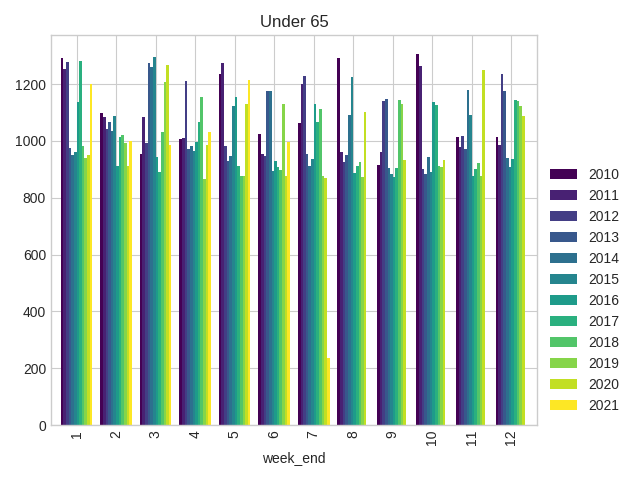

<IPython.core.display.Javascript object>


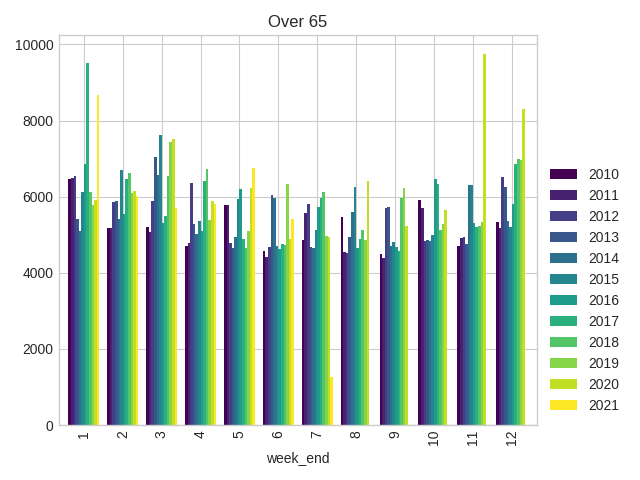

<IPython.core.display.Javascript object>


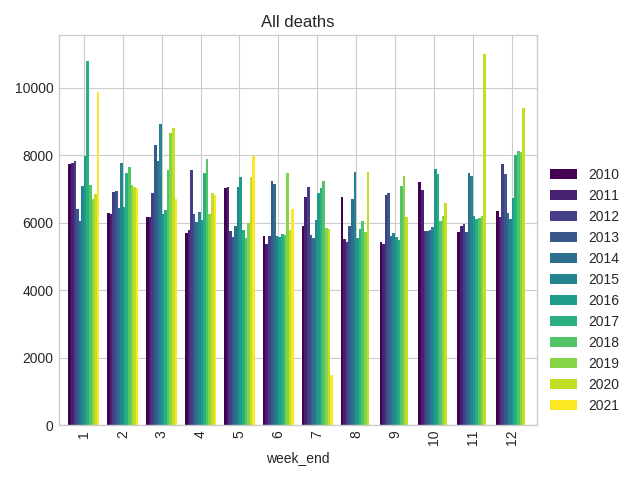

In [153]:
FROM_YEAR = 2010
compare_months_years(G.under_65, title='Under 65', from_year=FROM_YEAR,)
compare_months_years(G.over_65, title='Over 65', from_year=FROM_YEAR,)
compare_months_years(all_deaths, title='All deaths', from_year=FROM_YEAR,)

In [ ]:
compare_months_years(G.over_65, from_year=2018)